<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importando-dataframe" data-toc-modified-id="Importando-dataframe-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importando dataframe</a></span></li><li><span><a href="#Refinamento-do-tratamento-do-dado" data-toc-modified-id="Refinamento-do-tratamento-do-dado-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Refinamento do tratamento do dado</a></span><ul class="toc-item"><li><span><a href="#Removendo-valores-faltantes" data-toc-modified-id="Removendo-valores-faltantes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Removendo valores faltantes</a></span></li><li><span><a href="#Remoção-de-outliers-por-idade" data-toc-modified-id="Remoção-de-outliers-por-idade-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Remoção de <em>outliers</em> por idade</a></span></li></ul></li><li><span><a href="#Separando-treino-e-teste,-e-normalizando-o-dado" data-toc-modified-id="Separando-treino-e-teste,-e-normalizando-o-dado-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Separando treino e teste, e normalizando o dado</a></span><ul class="toc-item"><li><span><a href="#Separando-treino-e-teste-(70-30)" data-toc-modified-id="Separando-treino-e-teste-(70-30)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Separando treino e teste (70-30)</a></span></li><li><span><a href="#Normalizando-o-treino" data-toc-modified-id="Normalizando-o-treino-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Normalizando o treino</a></span><ul class="toc-item"><li><span><a href="#Aplicando-normalização-no-teste" data-toc-modified-id="Aplicando-normalização-no-teste-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Aplicando normalização no teste</a></span></li></ul></li><li><span><a href="#Dados-balanceados" data-toc-modified-id="Dados-balanceados-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Dados balanceados</a></span></li></ul></li></ul></div>

# Tratamento dos dados para treino e teste

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH, MODEL_PATH

import os
from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

# Metrics
from plot_metrics import plot_roc, plot_confusion

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

colorscale = ['#025951', '#8BD9CA', '#BF7F30', '#F2C124', '#8C470B', '#DFC27D']

## Importando dataframe

In [2]:
df = pd.read_csv(TREAT_PATH / 'analysis' / 'df_alunos.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182838 entries, 0 to 182837
Data columns (total 19 columns):
ID                            182838 non-null int64
CO_ENTIDADE                   182838 non-null int64
TP_SEXO                       182838 non-null int64
NU_IDADE                      182838 non-null int64
IN_DISTORCAO                  182838 non-null int64
IN_TRANSPORTE_PUBLICO         182838 non-null int64
IN_LOCAL_ESCOLA               182838 non-null int64
N_TURMA                       182838 non-null int64
IN_EVASAO                     182838 non-null int64
NU_ANO_CENSO                  182838 non-null int64
CO_MUNICIPIO                  182838 non-null int64
IN_LABORATORIO_INFORMATICA    182838 non-null float64
IN_LABORATORIO_CIENCIAS       182838 non-null float64
IN_QUADRA_ESPORTES            182838 non-null float64
IN_BIBLIOTECA                 182838 non-null float64
IN_BANHEIRO_FORA_PREDIO       182838 non-null float64
IN_AREA_VERDE                 182838 non-null f

In [3]:
df = df.drop('NU_ANO_CENSO', axis=1)
df.head(2)

,ID,CO_ENTIDADE,TP_SEXO,NU_IDADE,IN_DISTORCAO,IN_TRANSPORTE_PUBLICO,IN_LOCAL_ESCOLA,N_TURMA,IN_EVASAO,CO_MUNICIPIO,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_BANHEIRO_FORA_PREDIO,IN_AREA_VERDE,IN_N_COMP_15,NIVEL
0,112132289130,33009627,2,17,0,0,2,0,0,3301009,1.0,1.0,1.0,1.0,1.0,0.0,1,3.0
1,113220290328,33009627,2,21,1,0,2,0,1,3301009,1.0,1.0,1.0,1.0,1.0,0.0,1,3.0


In [4]:
df['IN_EVASAO'].value_counts(normalize=True)

0    0.657172
1    0.342828
Name: IN_EVASAO, dtype: float64

## Refinamento do tratamento do dado

### Removendo valores faltantes

~18% das observações não possui nível socioeconômico. De resto, possuem todas as outras features. 
* Dentre esses, temos ~23% dos evadidos da base total. Isso não muda muito a proporção: removendo essas observações passamos de 34 para 32% de evadidos na base utilizada.

In [5]:
df_null = df[df.isnull().any(axis=1)]
df_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33604 entries, 22 to 182837
Data columns (total 18 columns):
ID                            33604 non-null int64
CO_ENTIDADE                   33604 non-null int64
TP_SEXO                       33604 non-null int64
NU_IDADE                      33604 non-null int64
IN_DISTORCAO                  33604 non-null int64
IN_TRANSPORTE_PUBLICO         33604 non-null int64
IN_LOCAL_ESCOLA               33604 non-null int64
N_TURMA                       33604 non-null int64
IN_EVASAO                     33604 non-null int64
CO_MUNICIPIO                  33604 non-null int64
IN_LABORATORIO_INFORMATICA    33604 non-null float64
IN_LABORATORIO_CIENCIAS       33604 non-null float64
IN_QUADRA_ESPORTES            33604 non-null float64
IN_BIBLIOTECA                 33604 non-null float64
IN_BANHEIRO_FORA_PREDIO       33604 non-null float64
IN_AREA_VERDE                 33604 non-null float64
IN_N_COMP_15                  33604 non-null int64
NIVEL     

* Percentual de observações removidas

In [6]:
100*len(df_null)/len(df)

18.37911156324178

In [7]:
df_null['IN_EVASAO'].value_counts(normalize=True)

0    0.570498
1    0.429502
Name: IN_EVASAO, dtype: float64

* Percentual de evadidos e não evadidos removido

In [8]:
100*df_null['IN_EVASAO'].value_counts()/df['IN_EVASAO'].value_counts()

0    15.955092
1    23.025749
Name: IN_EVASAO, dtype: float64

In [9]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149234 entries, 0 to 182836
Data columns (total 18 columns):
ID                            149234 non-null int64
CO_ENTIDADE                   149234 non-null int64
TP_SEXO                       149234 non-null int64
NU_IDADE                      149234 non-null int64
IN_DISTORCAO                  149234 non-null int64
IN_TRANSPORTE_PUBLICO         149234 non-null int64
IN_LOCAL_ESCOLA               149234 non-null int64
N_TURMA                       149234 non-null int64
IN_EVASAO                     149234 non-null int64
CO_MUNICIPIO                  149234 non-null int64
IN_LABORATORIO_INFORMATICA    149234 non-null float64
IN_LABORATORIO_CIENCIAS       149234 non-null float64
IN_QUADRA_ESPORTES            149234 non-null float64
IN_BIBLIOTECA                 149234 non-null float64
IN_BANHEIRO_FORA_PREDIO       149234 non-null float64
IN_AREA_VERDE                 149234 non-null float64
IN_N_COMP_15                  149234 non-null

In [10]:
df['IN_EVASAO'].value_counts(normalize=True)

0    0.676689
1    0.323311
Name: IN_EVASAO, dtype: float64

### Remoção de *outliers* por idade

Nos primeiros testes com modelos, a idade se apresentou como o fator mais relevante (0.2 de importância no *Random Forest*). Consertamos aqui o tratamento dessa variável removendo valores muito discrepantes: > 99% dos dados i.e. acima de 21 anos de idade.

(<matplotlib.axes._subplots.AxesSubplot at 0x10ba35b90>, count    149234.000000
 mean         16.675034
 std           1.798304
 min          12.000000
 25%          16.000000
 50%          16.000000
 75%          17.000000
 max          77.000000
 Name: NU_IDADE, dtype: float64)

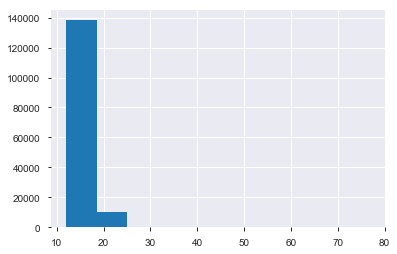

In [11]:
df['NU_IDADE'].hist(), df['NU_IDADE'].describe()

* Idade no quantil-99 (cauda)

In [12]:
np.quantile(df['NU_IDADE'], 0.99)

21.0

* Filtrando a cauda das idades

In [13]:
df = df[df['NU_IDADE'] <= np.quantile(df['NU_IDADE'], 0.99)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147944 entries, 0 to 182836
Data columns (total 18 columns):
ID                            147944 non-null int64
CO_ENTIDADE                   147944 non-null int64
TP_SEXO                       147944 non-null int64
NU_IDADE                      147944 non-null int64
IN_DISTORCAO                  147944 non-null int64
IN_TRANSPORTE_PUBLICO         147944 non-null int64
IN_LOCAL_ESCOLA               147944 non-null int64
N_TURMA                       147944 non-null int64
IN_EVASAO                     147944 non-null int64
CO_MUNICIPIO                  147944 non-null int64
IN_LABORATORIO_INFORMATICA    147944 non-null float64
IN_LABORATORIO_CIENCIAS       147944 non-null float64
IN_QUADRA_ESPORTES            147944 non-null float64
IN_BIBLIOTECA                 147944 non-null float64
IN_BANHEIRO_FORA_PREDIO       147944 non-null float64
IN_AREA_VERDE                 147944 non-null float64
IN_N_COMP_15                  147944 non-null

## Separando treino e teste, e normalizando o dado

Utilizamos um *encoder* ordinal para a categorização, com 70% separado para treino.

In [14]:
# Unicidade do ID
df['ID'].value_counts()[:5]

111677686633    1
144795399807    1
116663420410    1
116469827038    1
114949151540    1
Name: ID, dtype: int64

In [15]:
df = df.set_index('ID', drop=True)

X = df.columns
X = X.drop('IN_EVASAO')
df_x = df[X]

df_x.head(2)

,CO_ENTIDADE,TP_SEXO,NU_IDADE,IN_DISTORCAO,IN_TRANSPORTE_PUBLICO,IN_LOCAL_ESCOLA,N_TURMA,CO_MUNICIPIO,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_BANHEIRO_FORA_PREDIO,IN_AREA_VERDE,IN_N_COMP_15,NIVEL
ID,,,,,,,,,,,,,,,,
112132289130,33009627,2,17,0,0,2,0,3301009,1.0,1.0,1.0,1.0,1.0,0.0,1,3.0
113220290328,33009627,2,21,1,0,2,0,3301009,1.0,1.0,1.0,1.0,1.0,0.0,1,3.0


In [16]:
y = df['IN_EVASAO']
y.head()

ID
112132289130    0
113220290328    1
112752673352    0
117459545545    0
113868062938    1
Name: IN_EVASAO, dtype: int64

### Separando treino e teste (70-30)

In [20]:
# from sklearn.model_selection import train_test_split 
# X_train, X_test, y_train, y_test = train_test_split(df_x, y, test_size=0.3, random_state=0)

# # Salvando treino e teste
# X_train.join(y_train).to_csv(TREAT_PATH / 'modelo' / 'df_treino_bruto.csv')
# X_test.join(y_test).to_csv(TREAT_PATH / 'modelo' / 'df_teste_bruto.csv')

X_train = pd.read_csv(TREAT_PATH / 'modelo' / 'df_treino_bruto.csv', index_col='ID')
y_train = X_train['IN_EVASAO']
X_train = X_train.drop('IN_EVASAO', axis=1)

X_test = pd.read_csv(TREAT_PATH / 'modelo' / 'df_teste_bruto.csv', index_col='ID')
y_test = X_test['IN_EVASAO']
X_test = X_test.drop('IN_EVASAO', axis=1)

In [21]:
X_train.head()

,CO_ENTIDADE,TP_SEXO,NU_IDADE,IN_DISTORCAO,IN_TRANSPORTE_PUBLICO,IN_LOCAL_ESCOLA,N_TURMA,CO_MUNICIPIO,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_BANHEIRO_FORA_PREDIO,IN_AREA_VERDE,IN_N_COMP_15,NIVEL
ID,,,,,,,,,,,,,,,,
113112940902,33053383,2,18,1,1,1,1,3302502,1.0,1.0,1.0,1.0,1.0,1.0,0,3.0
116567624204,33049696,1,18,1,1,1,1,3301702,1.0,1.0,1.0,1.0,1.0,1.0,1,3.0
110334970619,33088900,2,16,0,1,1,0,3304904,0.0,1.0,1.0,1.0,1.0,1.0,0,3.0
114122977290,33089108,2,20,1,1,1,1,3304904,1.0,1.0,1.0,1.0,0.0,1.0,0,3.0
116861051771,33104344,2,16,0,1,1,1,3305109,1.0,0.0,1.0,1.0,1.0,1.0,1,3.0


In [40]:
len(set(X_train.values.flatten()))

954

In [22]:
X_test.head()

,CO_ENTIDADE,TP_SEXO,NU_IDADE,IN_DISTORCAO,IN_TRANSPORTE_PUBLICO,IN_LOCAL_ESCOLA,N_TURMA,CO_MUNICIPIO,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_BANHEIRO_FORA_PREDIO,IN_AREA_VERDE,IN_N_COMP_15,NIVEL
ID,,,,,,,,,,,,,,,,
122688991280,33048444,2,16,0,1,1,1,3301702,1.0,1.0,1.0,1.0,1.0,1.0,0,3.0
112004177984,33011842,1,16,0,0,2,0,3301009,1.0,1.0,1.0,1.0,0.0,1.0,0,3.0
111551586796,33162174,1,16,0,0,2,0,3305505,1.0,1.0,1.0,1.0,0.0,1.0,1,3.0
113447628919,33060193,1,16,0,1,1,0,3303500,1.0,1.0,1.0,1.0,1.0,1.0,0,3.0
118341995300,33104182,2,16,0,1,1,0,3304904,1.0,1.0,1.0,1.0,1.0,1.0,1,3.0


### Normalizando o treino

In [24]:
# from sklearn.preprocessing import OrdinalEncoder

# enc = OrdinalEncoder()
# X_norm = enc.fit_transform(X_train)

# # Salvando encoder
# import pickle
# filename = 'ordinal_encoder.sav'
# pickle.dump(enc, open(MODEL_PATH / filename, 'wb'))

import pickle
filename = 'ordinal_encoder.sav'
enc = pickle.load(open(MODEL_PATH / filename,"rb"))

In [46]:
len([item for sublist in enc.categories_ for item in sublist])

979

In [26]:
X_norm = pd.DataFrame(X_norm, columns=X_train.columns, index=X_train.index)
X_norm.head(2)

,CO_ENTIDADE,TP_SEXO,NU_IDADE,IN_DISTORCAO,IN_TRANSPORTE_PUBLICO,IN_LOCAL_ESCOLA,N_TURMA,CO_MUNICIPIO,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_BANHEIRO_FORA_PREDIO,IN_AREA_VERDE,IN_N_COMP_15,NIVEL
ID,,,,,,,,,,,,,,,,
113112940902,463.0,1.0,6.0,1.0,1.0,1.0,1.0,36.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0
116567624204,409.0,0.0,6.0,1.0,1.0,1.0,1.0,22.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


In [27]:
X_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103560 entries, 113112940902 to 110698097563
Data columns (total 16 columns):
CO_ENTIDADE                   103560 non-null float64
TP_SEXO                       103560 non-null float64
NU_IDADE                      103560 non-null float64
IN_DISTORCAO                  103560 non-null float64
IN_TRANSPORTE_PUBLICO         103560 non-null float64
IN_LOCAL_ESCOLA               103560 non-null float64
N_TURMA                       103560 non-null float64
CO_MUNICIPIO                  103560 non-null float64
IN_LABORATORIO_INFORMATICA    103560 non-null float64
IN_LABORATORIO_CIENCIAS       103560 non-null float64
IN_QUADRA_ESPORTES            103560 non-null float64
IN_BIBLIOTECA                 103560 non-null float64
IN_BANHEIRO_FORA_PREDIO       103560 non-null float64
IN_AREA_VERDE                 103560 non-null float64
IN_N_COMP_15                  103560 non-null float64
NIVEL                         103560 non-null float64
dtypes: 

#### Aplicando normalização no teste

In [28]:
X_test_norm = enc.transform(X_test)

In [29]:
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns, index=X_test.index)
X_test_norm.head(2)

,CO_ENTIDADE,TP_SEXO,NU_IDADE,IN_DISTORCAO,IN_TRANSPORTE_PUBLICO,IN_LOCAL_ESCOLA,N_TURMA,CO_MUNICIPIO,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_BANHEIRO_FORA_PREDIO,IN_AREA_VERDE,IN_N_COMP_15,NIVEL
ID,,,,,,,,,,,,,,,,
122688991280,388.0,1.0,4.0,0.0,1.0,1.0,1.0,22.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0
112004177984,79.0,0.0,4.0,0.0,0.0,2.0,0.0,14.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0


In [47]:
X_test_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44384 entries, 122688991280 to 110552183600
Data columns (total 16 columns):
CO_ENTIDADE                   44384 non-null float64
TP_SEXO                       44384 non-null float64
NU_IDADE                      44384 non-null float64
IN_DISTORCAO                  44384 non-null float64
IN_TRANSPORTE_PUBLICO         44384 non-null float64
IN_LOCAL_ESCOLA               44384 non-null float64
N_TURMA                       44384 non-null float64
CO_MUNICIPIO                  44384 non-null float64
IN_LABORATORIO_INFORMATICA    44384 non-null float64
IN_LABORATORIO_CIENCIAS       44384 non-null float64
IN_QUADRA_ESPORTES            44384 non-null float64
IN_BIBLIOTECA                 44384 non-null float64
IN_BANHEIRO_FORA_PREDIO       44384 non-null float64
IN_AREA_VERDE                 44384 non-null float64
IN_N_COMP_15                  44384 non-null float64
NIVEL                         44384 non-null float64
dtypes: float64(16)
memor

In [60]:
# X_test_norm.join(y_test).to_csv(TREAT_PATH / 'modelo' / 'df_teste.csv')
X_test_norm = pd.read_csv(TREAT_PATH / 'modelo' / 'df_teste.csv', index_col='ID')

### Dados balanceados

Problema dos dados desbalanceados: tendência para predição da classe dominante é maior, pois aumenta a acurácia do modelo - mas não necessariamente o *recall*, que é o nosso foco.


[Rebalanceamento](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb):

- Undersampling: remoção aleatória de observações da classe dominante

- Oversampling: geração de observações artificiais da classe minoritária
 - SMOTE (Synthetic Minority Over-sampling Technique): k nearest neighbours
 
Como temos muito dado, vamos escolher uma amostra aleatória da classe dominante para usar no treinamento do modelo.

In [50]:
from sklearn.utils import resample

df_maj = X_norm[X_norm.index.isin(y_train[y_train == 0].index)]
df_min = X_norm[X_norm.index.isin(y_train[y_train == 1].index)]

In [51]:
print(len(df_maj), len(df_min))

70402 33158


In [56]:
# # Selecionando uma amostra da classe majoritária
# df_maj = df_maj.sample(n=len(df_min),random_state=0)

# X_train_bal = df_min.append(df_maj)
# y_train_bal = y_train[y_train.index.isin(X_train_bal.index)]

# # Salvando treino balanceado
# X_train_bal.join(y_train_bal).to_csv(TREAT_PATH / 'modelo' / 'df_treino_bal.csv')

X_train_bal = pd.read_csv(TREAT_PATH / 'modelo' / 'df_treino_bal.csv', index_col='ID')
y_train_bal = X_train_bal['IN_EVASAO']
X_train_bal = X_train_bal.drop('IN_EVASAO', axis=1)

In [57]:
X_train_bal.head(2)

,CO_ENTIDADE,TP_SEXO,NU_IDADE,IN_DISTORCAO,IN_TRANSPORTE_PUBLICO,IN_LOCAL_ESCOLA,N_TURMA,CO_MUNICIPIO,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_QUADRA_ESPORTES,IN_BIBLIOTECA,IN_BANHEIRO_FORA_PREDIO,IN_AREA_VERDE,IN_N_COMP_15,NIVEL
ID,,,,,,,,,,,,,,,,
113112940902,463.0,1.0,6.0,1.0,1.0,1.0,1.0,36.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0
114122977290,644.0,1.0,8.0,1.0,1.0,1.0,1.0,69.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0


In [58]:
y_train_bal.head(2)

ID
113112940902    1
114122977290    1
Name: IN_EVASAO, dtype: int64

In [59]:
y_train_bal.value_counts()

1    33158
0    33158
Name: IN_EVASAO, dtype: int64